In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

In [3]:
from keras.models import load_model
ANNmodel = load_model('./Models')

ANNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                39768     
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 40393 (157.79 KB)
Trainable params: 40393 (157.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
data = pd.read_csv('final_cleaned.csv')
data.head()

,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = data.drop(['price', 'time'], axis=1)
fairness_data = data.copy()
fairness_data['predicted_price'] = ANNmodel.predict(X)
fairness_data.head()

313/313 [==============================] - 0s 439us/step


,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf,predicted_price
0,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1767.782959
1,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,609.471741
2,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1288.924805
3,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1575.438965
4,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1291.258179


In [6]:
# if the actual price is more than 30% more than the predicted price, the value in the fairness column is 'unfair', otherwise it is 'fair'
fairness_data['fairness'] = np.where(fairness_data['price'] > 1.3*fairness_data['predicted_price'], 'unfair', 'fair')
fairness_data['fairness'].value_counts()

fair      8992
unfair    1006
Name: fairness, dtype: int64

Accuracy of logistic regression classifier on test set: 0.94
Precision of logistic regression classifier on test set: 0.86
Recall of logistic regression classifier on test set: 0.47


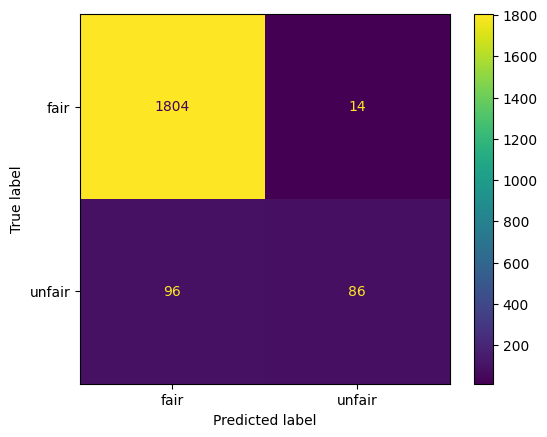

In [9]:
# drop time since machine cant train on DateTime type
X = fairness_data.drop(columns=['time', 'fairness', 'predicted_price'])
X_train, X_test, y_train, y_test = train_test_split(X, fairness_data.fairness, test_size = 0.2, random_state = 50)

logisticRegr = linear_model.LogisticRegression(max_iter=1000)

logisticRegr.fit(X_train, y_train)

pred = logisticRegr.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
myconfusionmatrix = confusion_matrix(y_test, pred, labels = ['fair', 'unfair'])

disp = ConfusionMatrixDisplay(confusion_matrix=myconfusionmatrix,
                            display_labels= ['fair', 'unfair'])


disp.plot()

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(X_test, y_test)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[0,1]+myconfusionmatrix[1,1])))
print('Recall of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[1,0]+myconfusionmatrix[1,1])))